# A Langevin-féle SDE és alkalmazásai


Az utóbbi időben, különösen a neurális hálók tanításával foglalkozók körében, igen közkedveltté vált az ún. *sztochasztikus gradiens Langevin dinamika* (SGLD), illete ennek különféle variánsai. Legyen $u:\mathbb{R}^d\to\mathbb{R}$ függvény, melynek $\nabla u:\mathbb{R}^d\to\mathbb{R}^d$ deriváltjáról feltesszük, hogy Lipschitz-folytonos. Ekkor igen enyhe feltételek mellett igaz, hogy tetszőleges fix $x_0$ kezdetiértéket és $\beta>0$ paramétert választva a
$$
d X_t = -\nabla u (X_t) + \sqrt{\frac{2}{\beta}}dB_t
$$
szochasztikus differenciálegyenlet $(X_t)_{t\ge 0}$ megoldásának pillanatnyi értéke eloszlásban stacionárius eloszláshoz konvergál:
$$
\mathrm{Law}(X_t)\to\pi_{\beta} (dx)\propto e^{-\beta u(x)}dx,\,\,\,\,t\to\infty.
$$
A fizikai analógia alapján a $\beta>0$ paramétert szokás *inverz hőmérséklet*-nek is nevezni.

Erre a jelenségre alapozva:

1. szinte tetszőleges folytonos eloszlásból hatékonyan generálhatunk véletlen vektorokat; 

2. $\beta$ értékét nagyra választva a $\pi_{\beta}$ eloszlás, és így az $X_t$ értékek is, $u$ globális minimuma körül koncentrálódnak. Ez teszi lehetővé, hogy akár bonyolult, és igen magas dimenziós téren értelmezett nem feltétlenül konvex függvények globális szélsőértékét megkeressük.

Főleg gépi tanulási alkalmazásokban előfordulhat az is, hogy $\nabla u:\mathbb{R}^d\to\mathbb{R}^d$ derivált nem ismert, és csak egy ún. torzítatlan becslése áll a rendelkezésünkre. Tehát adott egy $H:\mathbb{R}^d\to\mathbb{R}^m\to\mathbb{R}^d$ függvény és $(Y_n)_{n\in\mathbb{N}}$ tanító adatfolyam, mely utóbbi egy i.i.d. sorozat, és igaz az, hogy
$$
\mathbb{E}(H(x,Y_0)) = \nabla u(x),\,\,\,\,x\in\mathbb{R}^d.
$$

Ekkor alkalmas $\lambda>0$ lépésközt (learning rate) választva az
$$
X_0 = x_0,\,\,\,X_{n+1}=X_n-\lambda H(X_n,Y_n)+\sqrt{\frac{2\lambda}{\beta}}\xi_{n+1}
$$
iterációval kereshetjük meg $u$ globális minimumát, ahol $(\xi_{n})_{n\in\mathbb{N}}$ standard normális eloszlású valószínűségi változók i.i.d. sorozata.

In [54]:
import autograd.numpy as np

def sgld(H, x0, learning_rate, beta):
    """
    Sztochasztikus gradiens Langevin algoritmus
    
    H -- sztochasztikus gradiens H(x)
    x0 -- kezdőérték
    learning_rate -- lépésköz
    beta -- zaj paraméter
    """
    
    X = x0
    if isinstance(x0, float):
        s = None
    else:
        s = x0.shape
    
    while True:
        yield X
        X = X-learning_rate*H(X)+np.sqrt(2*learning_rate/beta)*np.random.normal(size=s) 

# Előírt eloszlású véletlen vektor generálása

## Példa

A Gumbel-eloszlás az extrém-érték elméletben előforduló egyik fontos eloszlás típus. A standard Gumbel-eloszlású valószínűségi változó sűrűségfüggvénye 
$$
f(x)=e^{-(x+e^{-x})},\,\,\,x\in\mathbb{R}.
$$

Az alábbi programkódon segítségével Gumbel eloszlású valószínűségi változót generálhatunk.

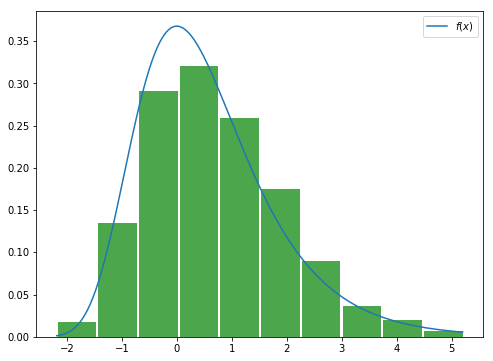

In [126]:
import autograd.numpy as np
from autograd import elementwise_grad
import matplotlib.pyplot as plt

u = lambda x: x+np.exp(-x)
h = elementwise_grad(u)

f = lambda x: np.exp(-u(x))

Nwarmup = 1000  # ennyi iteráció után az eloszlás kb. stacionárius
x0 = 0.0 # kezdőérték
N = 10000 # ennyit mintát generálunk
beta = 1.0
learning_rate = 0.025

X = sgld(h, x0, learning_rate, beta)

for k in range(Nwarmup):
    next(X);

sample = np.array([next(X) for k in range(N)])

_, ax = plt.subplots(1, 1, figsize=(8,6))

x = np.arange(np.min(sample),np.max(sample),0.02)
ax.plot(x,f(x),label='$f(x)$')
ax.hist(sample,density=True,color ='green',alpha = 0.7,rwidth=0.95);
ax.legend();

## Feladat

A fenti módszerrel szimuláljunk kétdimenziós normális eloszlású valószínűségi változót tetszőleges, rögzített paraméterekkel. Készítsünk kétdimenziós ún. *density plot*-ot és vizsgáljunk normalitást.

# Nemkonvex függvény globális minimumának megkeresése

## Példa

Keressük meg az $u(x)=(10(x+1)^2+1)((x-4)^2+1)$ polinomfüggvény globális minimumhelyét az $x_0=4.2$ pontból kiindulva a fent ismertetett sztochasztikus gradiens Langevin algoritmus segítségével.

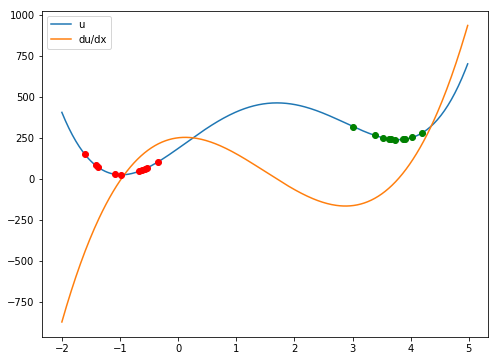

In [103]:
import autograd.numpy as np
from autograd import elementwise_grad
import matplotlib.pyplot as plt

u = lambda x: (10*(x+1)**2.0+1)*((x-4)**2.0+1)
h = elementwise_grad(u)

x0 = 4.2 # kezdőérték
N = 1000 # ennyit iterálunk
beta = 0.02
learning_rate = 0.0025

X = sgld(h, x0, learning_rate, beta)

iterates = np.array([next(X) for k in range(N)])

_, ax = plt.subplots(1, 1, figsize=(8,6))

x = np.arange(-2,5,0.02)
ax.plot(x,u(x),label='u')
ax.plot(x,h(x),label='du/dx')
ax.plot(iterates[:10], u(iterates[:10]),'go')
ax.plot(iterates[-10:], u(iterates[-10:]),'ro')

ax.legend()

## Feladat

Implementáljuk a közönséges gradiens módszer algoritmust, és azonos kezdőértékből indulva, a lépésközt variálva próbáljuk meg megkeresni a fenti példában szereplő függvény globális minimumát. Mit tapasztalunk?

Tegyük fel, hogy $u$ deriváltja nem áll rendelkezésünkre, csak annak az alábbi $H$ becslése (egyébként ez most pont nem torzítatlan, de ha akarjuk azzá tehetjük). Ismételjük meg a fenti kísérleteket mind a közönséges, mind pedig a sztochasztikus gradiens algoritmussal. Mit tapasztalunk?

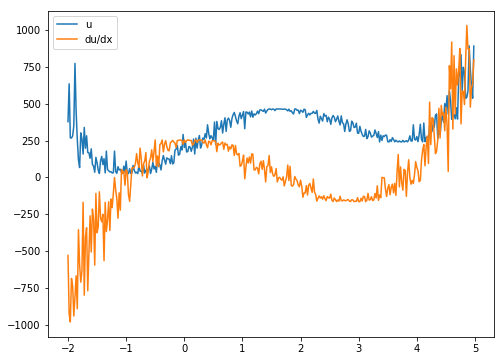

In [108]:
import autograd.numpy as np
from autograd import elementwise_grad
import matplotlib.pyplot as plt

# Zajos u
U = lambda x: u(x+0.2*np.random.normal(size=x.shape))
H = elementwise_grad(U)

_, ax = plt.subplots(1, 1, figsize=(8,6))

x = np.arange(-2,5,0.02)
ax.plot(x,U(x),label='u')
ax.plot(x,H(x),label='du/dx')

ax.legend()

## Feladat

A sztochasztikus gradiens Langevin algoritmusnak a fent ismertetett formáját *állandó lépésközű* változatnak nevezik és elsősorban azokban olyan alkalmazásokban népszerű, ahol a célfüggvény folyton változik (online learning, tracking problem). 

Létezik azonban változó lépésközű változat is, ahol $\beta$ fix, a $(\lambda_n)_{n\in\mathbb{N}}$ sorozatot pedig úgy választják, hogy $\sum_{k=0}^\infty \lambda_n=\infty$ és $\sum_{k=0}^\infty \lambda_n^2 < \infty$ teljesüljön. Implelentáljuk ezt a változatot, és alkalmas kezdő paraméter értékeket választva futtassuk az algoritmust a fenti példákban szereplő függvényeken.

# További olvasnivalók

1. https://en.wikipedia.org/wiki/Langevin_dynamics
2. https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics
3. https://www.stats.ox.ac.uk/~teh/research/compstats/WelTeh2011a.pdf
4. https://arxiv.org/pdf/2009.09535.pdf
5. https://arxiv.org/abs/2006.14514
6. https://arxiv.org/abs/1702.03849
7. https://arxiv.org/abs/2210.02092